## Goal 

Use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. <br>
<br>
Specifically, build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores. You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales. <br>
<br>
READ : <br>
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this. <br>
<br>
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns 
from tqdm import tqdm 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import OneHotEncoder

The **training data**, comprising time series of features store_nbr, family, and onpromotion as well as the target sales : <br>
<br>
- **store_nbr** identifies the store at which the products are sold <br>
<br>
- **family** identifies the type of product sold <br>
<br>
- **sales** gives the total sales for a product family at a particular store at a given date <br>
Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips). <br>
<br>
- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date. <br>
<br>
<br>
Test csv looks like train csv. <br>
Target : predict '**sales**' in the test csv. <br>
The dates in the test data are for the 15 days after the last date in the training data.

# ADA + treating data

In [4]:
dossier = '/Users/augustincablant/Desktop/Python/Kaggle/store-sales-time-series-forecasting/'
df_train = pd.read_csv(dossier+'train.csv')
family_products = list(df_train['family'].unique())
df_test = pd.read_csv(dossier+'test.csv')
"""
plt.figure(figsize=(18, 8))
for product in family_products: 
    sns.lineplot(x= 'date', y= 'sales', data=df_train[df_train['family']==product], label=f'Ventes de {product}')
    
plt.title('Évolution du nombre de ventes dans le magasin Favorita')
plt.legend()
plt.show()
"""

"\nplt.figure(figsize=(18, 8))\nfor product in family_products: \n    sns.lineplot(x= 'date', y= 'sales', data=df_train[df_train['family']==product], label=f'Ventes de {product}')\n    \nplt.title('Évolution du nombre de ventes dans le magasin Favorita')\nplt.legend()\nplt.show()\n"

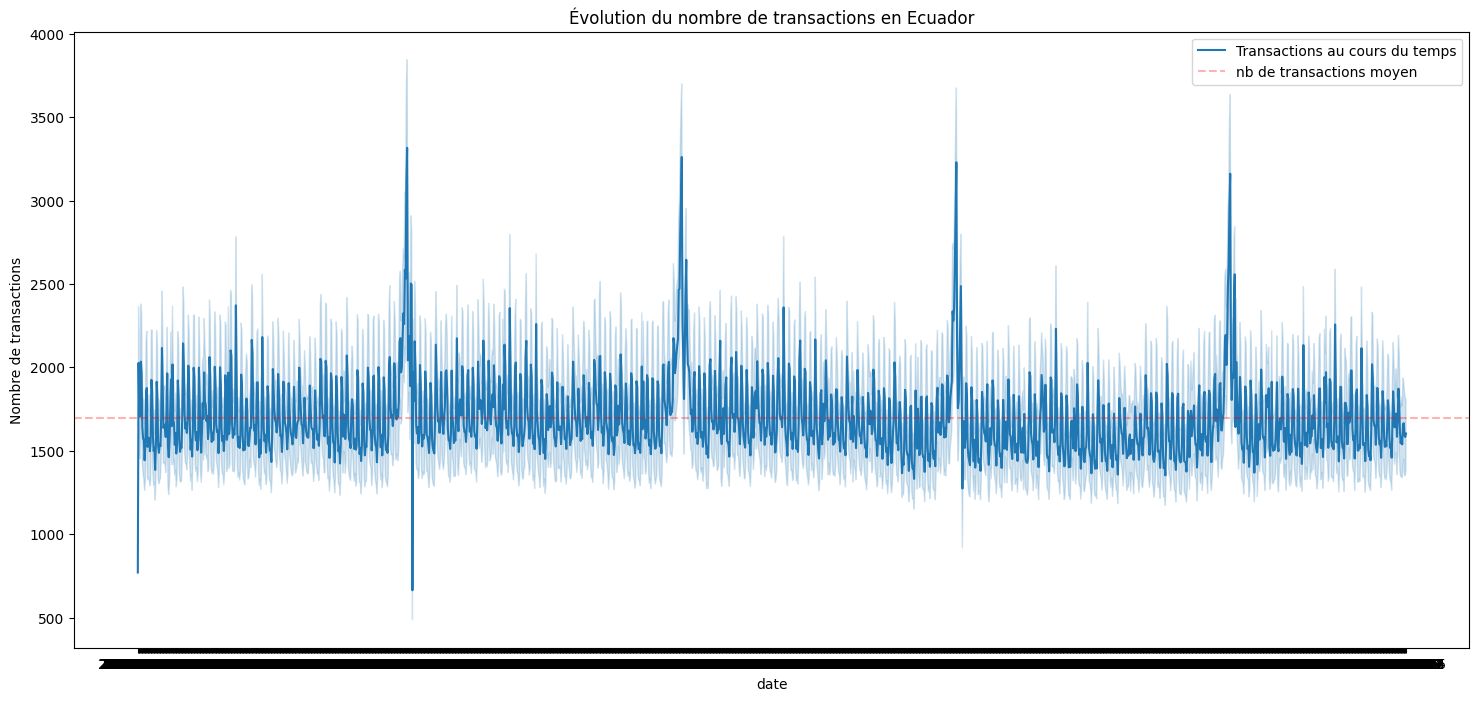

In [8]:
transaction = pd.read_csv(dossier+'transactions.csv')


plt.figure(figsize=(18, 8))
sns.lineplot(x= 'date', y= 'transactions', data=transaction, label='Transactions au cours du temps')
plt.axhline(transaction['transactions'].mean(), color='red', linestyle='--', alpha=0.3,label='nb de transactions moyen')
plt.xlabel('date')
plt.ylabel('Nombre de transactions')
plt.title('Évolution du nombre de transactions en Ecuador')
plt.legend()
plt.show()

Store metadata, including city, state, type, and cluster <br>
<br>
cluster is a grouping of similar stores.

In [5]:
store = pd.read_csv(dossier+'stores.csv')
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

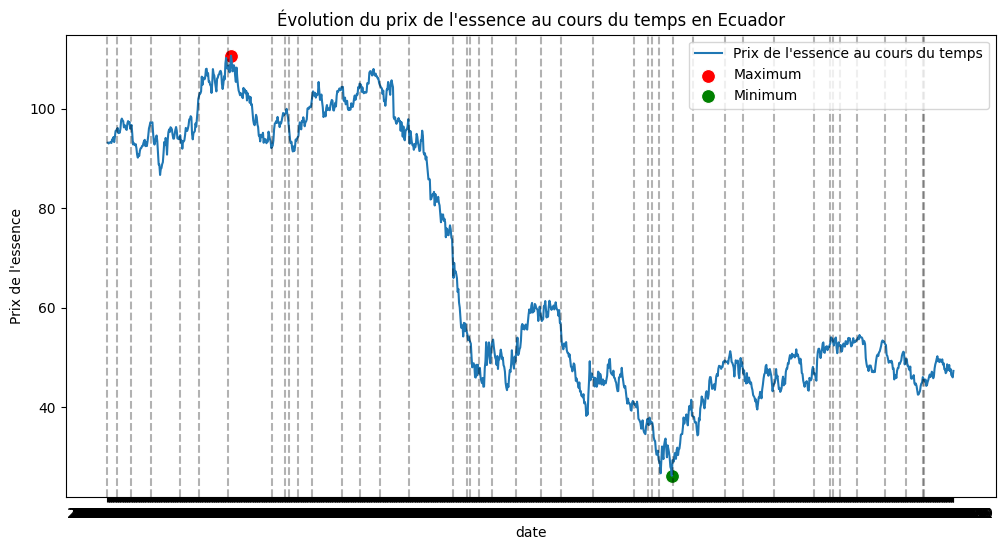

In [13]:
oil = pd.read_csv(dossier+'oil.csv')
plt.figure(figsize=(12, 6))
sns.lineplot(x= 'date', y= 'dcoilwtico', data=oil, label='Prix de l\'essence au cours du temps')

# max and min
max_points = oil[oil['dcoilwtico'] == oil['dcoilwtico'].max()]
min_points = oil[oil['dcoilwtico'] == oil['dcoilwtico'].min()]

sns.scatterplot(x=max_points['date'], y=max_points['dcoilwtico'], color='red', label='Maximum', s=100 )
sns.scatterplot(x=min_points['date'], y=min_points['dcoilwtico'], color='green', label='Minimum', s=100)

# Marquer les moments de rupture en bleu
moments_rupture = list(oil[oil['dcoilwtico'].isnull()]['date'])
rupture_prices = oil[oil['date'].isin(moments_rupture)]
#sns.scatterplot(x=rupture_prices['date'], y=rupture_prices['dcoilwtico'], color='black', label='Moments de rupture',s=0.5)

for moment_date in moments_rupture:
    plt.axvline(moment_date, color='black', linestyle='--', alpha=0.3)


plt.xlabel('date')
plt.ylabel('Prix de l\'essence')
plt.title('Évolution du prix de l\'essence au cours du temps en Ecuador')
plt.legend()


plt.show()

In [9]:
transaction.head()
transaction_sum = transaction[['date','transactions']].groupby('date')['transactions'].sum().reset_index()
transaction_sum.head()

,date,transactions
0,2013-01-01,770
1,2013-01-02,93215
2,2013-01-03,78504
3,2013-01-04,78494
4,2013-01-05,93573


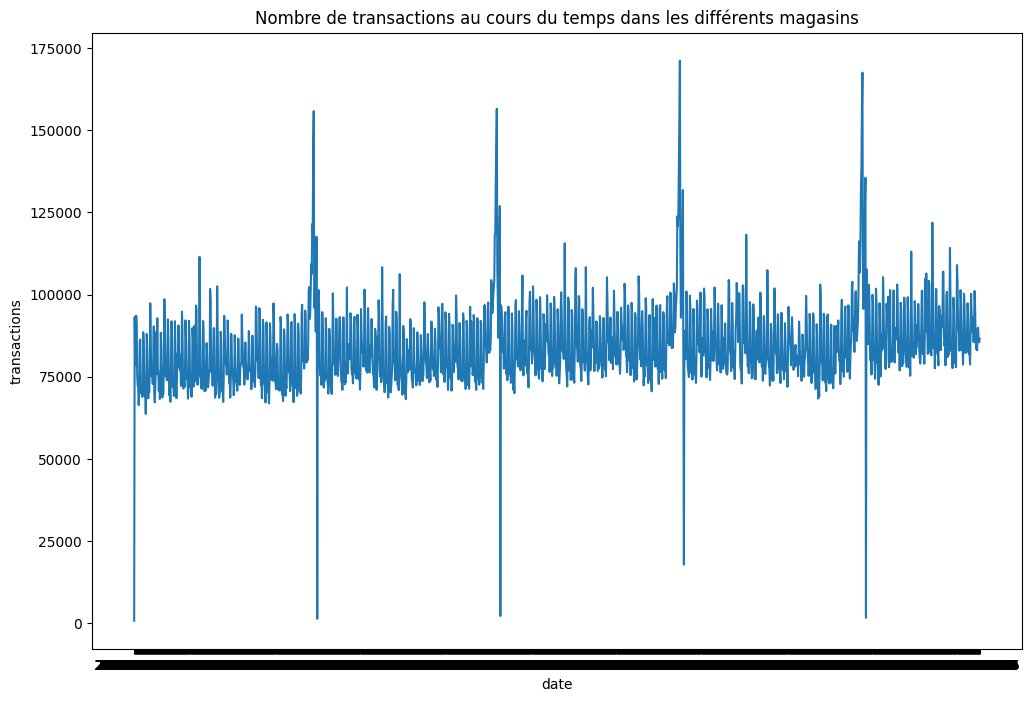

In [26]:
plt.figure(figsize=(12,8))
sns.lineplot(x = 'date', y= 'transactions', data = transaction_sum)
plt.title('Nombre de transactions au cours du temps dans les différents magasins')
plt.show()

In [10]:
holidays_event = pd.read_csv(dossier+'holidays_events.csv')
liste_local_name = list(holidays_event['locale_name'].unique())
holidays_event[holidays_event['locale_name']=='Ecuador']

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Création du data set de travail en conservant les colonnes qui nous sont utiles :

In [28]:
# ajouter le nombre de transactions 
df = pd.merge(df_train, transaction[['date','transactions']], on='date', how='left')
# ajouter le prix de l'essence
df = pd.merge(df, oil, on='date', how='left')
# ajouter les informations sur les magasins
df = pd.merge(df, store[['city','type','cluster','store_nbr']], on = 'store_nbr', how = 'left')

# créer une variable binaire pour les évènements 
event = holidays_event.copy()
event = event.rename({'locale_name':'city'},axis=1)
event = event.drop(['description','transferred'],axis=1)

event['national_event'] = 0
event['local_event'] = 0 

for i in tqdm(holidays_event.index.to_list()):
    if holidays_event['locale'][i]=='National':
        event.loc[i,'national_event'] = 1
    else:
        event.loc[i,'local_event'] = 1

event = event.drop('locale',axis=1)

# ajouter les informations sur les event 
df = pd.merge(df,event,on = ['date','city'], how='left')
df['national_event'] = df['national_event'].fillna(0)
df['local_event'] = df['local_event'].fillna(0)

df =df.drop(['type_x','type_y','city'],axis=1)
df.sample(10)

100%|██████████| 350/350 [00:00<00:00, 12518.28it/s]


,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,cluster,national_event,local_event
123450037,2524520,2016-11-20,42,LAWN AND GARDEN,24.000000,0,841.0,NaN,2,0.0,0.0
126767006,2587519,2016-12-27,10,"LIQUOR,WINE,BEER",9.000000,0,1491.0,52.82,15,0.0,0.0
122376036,2503729,2016-11-09,1,LADIESWEAR,22.000000,0,972.0,45.20,13,0.0,0.0
45235056,973519,2014-07-02,24,LADIESWEAR,0.000000,0,3015.0,105.18,1,0.0,0.0
109593984,2257644,2016-06-23,54,HOME AND KITCHEN I,6.000000,0,619.0,49.34,3,0.0,0.0
137641314,2794372,2017-04-22,14,SCHOOL AND OFFICE SUPPLIES,0.000000,0,1949.0,NaN,7,0.0,0.0
106771869,2204397,2016-05-25,10,PRODUCE,139.060000,1,1745.0,49.10,15,0.0,0.0
109189452,2250011,2016-06-19,40,BREAD/BAKERY,439.000000,49,1250.0,NaN,3,0.0,0.0
60571710,1295248,2014-12-30,50,SCHOOL AND OFFICE SUPPLIES,1.000000,0,4801.0,54.14,14,0.0,0.0
86401503,1814603,2015-10-18,23,SEAFOOD,19.793999,0,1126.0,NaN,9,0.0,0.0


In [30]:
df.to_parquet(dossier+'df_train.parquet')

In [ ]:
# Idem pour le df_test
df_t = pd.merge(df_test, transaction[['date','transactions']], on='date', how='left')
df_t = pd.merge(df_t, oil, on='date', how='left')
df_t = pd.merge(df_t, store[['city','type','cluster','store_nbr']], on = 'store_nbr', how = 'left')

event = holidays_event.copy()
event = event.rename({'locale_name':'city'},axis=1)
event = event.drop(['description','transferred'],axis=1)

event['national_event'] = 0
event['local_event'] = 0 

for i in tqdm(holidays_event.index.to_list()):
    if holidays_event['locale'][i]=='National':
        event.loc[i,'national_event'] = 1
    else:
        event.loc[i,'local_event'] = 1

event = event.drop('locale',axis=1)
df_t = pd.merge(df_t,event,on = ['date','city'], how='left')
df_t['national_event'] = df_t['national_event'].fillna(0)
df_t['local_event'] = df_t['local_event'].fillna(0)

df_t =df_t.drop(['type_x','type_y','city','transactions'],axis=1)
df_t.to_parquet(dossier+'df_test.parquet')

# Preprocessing

In [3]:
dossier = '/Users/augustincablant/Desktop/Python/Kaggle/store-sales-time-series-forecasting/'
df_train = pd.read_parquet(dossier+'df_train.parquet')
df_test = pd.read_parquet(dossier+'df_test.parquet')

In [4]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,cluster,national_event,local_event
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,770.0,NaN,13,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,770.0,NaN,13,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,770.0,NaN,13,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,770.0,NaN,13,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,770.0,NaN,13,0.0,0.0


In [5]:
family_liste = list(df_train['family'].unique())
print(family_liste)
print(len(family_liste))

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
33


In [8]:
df_train[df_train['dcoilwtico'].notnull()].sample()

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,cluster,national_event,local_event
49574349,1065427,2014-08-22,52,"LIQUOR,WINE,BEER",0.0,0,1246.0,93.61,11,0.0,0.0


In [6]:
def preprocessing(df):
    df = missing_values(df)
    df = encode(df)
    return df 

def missing_values(df):
    df = df.dropna()
    return df

dico_encoding = {f'{fam}': k + 1 for k,fam in enumerate(family_liste)}
def encode(df): 
    df['family'] = df['family'].map(dico_encoding)
    return df 

df_train = preprocessing(df_train)
df_test = preprocessing(df_test)

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_1818/477952195.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['family'] = df['family'].map(dico_encoding)
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_1818/477952195.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['family'] = df['family'].map(dico_encoding)


In [24]:
df_train.sample(10)

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,cluster,national_event,local_event
19035197,412587,2013-08-20,35,22,0.0,0,2300.0,104.90,3,0.0,0.0
9870404,216317,2013-05-02,29,3,0.0,0,892.0,93.70,10,0.0,0.0
10941957,239366,2013-05-15,25,18,0.0,0,3269.0,93.95,1,0.0,0.0
115920949,2377543,2016-08-30,19,26,167.0,5,2635.0,46.32,15,0.0,0.0
73460107,1561224,2015-05-29,14,28,0.0,0,2416.0,60.25,7,0.0,0.0
83900910,1766833,2015-09-21,33,14,7.0,0,3108.0,46.67,3,0.0,0.0
148165921,2989272,2017-08-09,33,1,7.0,0,1212.0,49.59,3,0.0,0.0
15538478,337366,2013-07-09,25,8,242.0,0,3032.0,103.46,1,0.0,0.0
93337394,1945469,2015-12-31,45,21,35.0,0,1658.0,37.13,11,0.0,0.0
57308818,1227271,2014-11-21,44,2,0.0,0,665.0,76.52,5,0.0,0.0


In [7]:
FEATURES = ['date', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'cluster', 'national_event', 'local_event' ]
TARGET = ['sales']

# Séparer les données en variables d'entrée (X) et cible (y)
X = df_train[FEATURES]
y = df_train[TARGET]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.to_parquet(dossier + 'X_train_split.parquet')
X_test.to_parquet(dossier + 'X_test_split.parquet')
y_train.to_parquet(dossier + 'y_train_split.parquet')
y_test.to_parquet(dossier + 'y_test_split.parquet')

In [18]:
# Créer le modèle XGBoost
model = RandomForestRegressor() 

# Entraîner le modèle
model.fit(X_train.drop('date',axis=1), y_train)

# Faire des prédictions
predictions = model.predict(X_test.drop('date',axis=1))

# Calculer la RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test, predictions))
print('RMSLE:', rmsle) 

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_1818/357002023.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train.drop('date',axis=1), y_train)
